In [2]:
%matplotlib inline

import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# digitsデータを使うためにimportする
from torchvision.datasets import CIFAR10
import torchvision

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cpu


In [4]:
trainset = CIFAR10(root='./data',
                     train=True,
                     download=True,
                transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize(224),
                    torchvision.transforms.ToTensor()
                ]))

testset = CIFAR10(root='./data',
                    train=False,
                    download=True,
                  transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize(224),
                    torchvision.transforms.ToTensor()
                ]))

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
test_loader = DataLoader(testset, batch_size=16, shuffle=True)

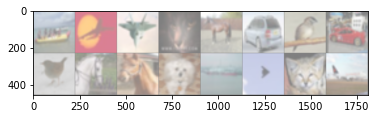

 ship plane plane   cat horse   car  bird   car  bird horse horse   dog  ship plane   cat plane


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## 転移学習
---
今回はVGG16を利用しました。

In [8]:
# Enter your code here
model_ft2 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/arakishimpei/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [9]:
# パラメーターを学習させないようにしている
# Enter your code here
for param in model_ft2.parameters():
    param.require_grad = False

In [10]:
# 最後の一層だけ書き換えて、最後の一層だけ学習させる
# Enter your code here
model_ft2.fc = nn.Linear(in_features=512, out_features=len(classes), bias=True)

In [11]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


In [12]:
optimizer = optim.SGD(model_ft2.parameters(), lr=0.001)

In [13]:
model_ft2 = model_ft2.to(device)

In [ ]:
train_loss_track = []
test_loss_track = []

for epoc in range(3):
    running_loss = 0
    running_test_loss = 0
    
    # 学習モード
    model_ft2.train()
    for step, (xx, yy)  in enumerate(train_loader):
        
        # device = "cuda"の場合、GPUにデータを転送する
        xx = xx.to(device)
        yy = yy.to(device)
        
        # 最後に計算した各パラメーターの勾配を初期化する
        optimizer.zero_grad()
        
        # フォワード計算を行う
        y_pred = model_ft2(xx)
        
        # 誤差関数を使ってギャップの計測
        loss = loss_func(y_pred, yy)
        
        # 誤差逆伝播法を使って自動微分
        loss.backward()
        
        # パラメーターを更新
        optimizer.step()
        
        # 学習データを使って損失を計算
        running_loss += loss.item()
        
        #途中経過出力
        if step % 10 == 0:
            print('[{:d}, {:5d}] loss: {}'
                    .format(epoc + 1, step + 1, running_loss / 100))
            running_loss = 0.0
        
    # エポックが終了したら平均損失を計算
    train_loss_track.append(running_loss/step)
    
    
    #評価（evaluation）モード
    model_ft2.eval()
    
    with torch.no_grad():
        for step, (xx_test, yy_test)  in enumerate(test_loader):
            
            # device = "cuda"の場合、GPUにデータを転送する
            xx_test = xx_test.to(device)
            yy_test = yy_test.to(device)

            # 予測値を計算
            y_pred = model_ft2(xx_test)

            # 誤差関数を使ってギャップの計測
            test_loss = loss_func(y_pred, yy_test)

            # テストデータを使って損失を計算
            running_test_loss += test_loss.item()
            
         # 誤差をトラッキング
        test_loss_track.append(running_test_loss / (step + 1))

[1,     1] loss: 0.1318262481689453
[1,    11] loss: 0.5607317876815796
[1,    21] loss: 0.4524465799331665
[1,    31] loss: 0.3543419575691223
[1,    41] loss: 0.3412498617172241
[1,    51] loss: 0.31019422054290774
[1,    61] loss: 0.2770808148384094
[1,    71] loss: 0.29615126848220824
[1,    81] loss: 0.26205585479736326
[1,    91] loss: 0.24204728484153748
[1,   101] loss: 0.25571027517318723


## 交差エントロピー誤差の推移

In [ ]:
plt.plot(train_loss_track)

In [ ]:
plt.plot(test_loss_track)

In [ ]:
true = 0
total = 0

all_labels = np.array([])
all_preds = np.array([])

with torch.no_grad():
    for test_xx, test_yy in test_loader:
        
        # device = "cuda"の場合、GPUにデータを転送する
        test_xx = test_xx.to(device)
        test_yy = test_yy.to(device)

        outputs = model_ft2(test_xx)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels = np.append(all_labels, test_yy.cpu().data.numpy())
        all_preds = np.append(all_preds, predicted.cpu().numpy())
        
        total += test_yy.size(0)
        true += (predicted == test_yy).sum().item()
print('Accuracy: {:.2f} %'.format(100 * float(true/total)))

## testデータで混同行列を作成

In [ ]:
labels = np.unique(all_labels)
cm = confusion_matrix(all_labels, all_preds, labels=labels)
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)
cm_labeled